In [27]:
from pyspark.sql.types import TimestampType
from pyspark.sql import functions as F
import datetime
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [28]:
# Change the path where dataset in located in dumbo 
dataset_filepath="/user/shs572/311_Service_Requests_from_2010_to_Present.csv"

In [29]:
df = spark.read.format('csv').options(header='true',inferschema='true').load(dataset_filepath)

In [30]:
df.columns

['Unique Key',
 'Created Date',
 'Closed Date',
 'Agency',
 'Agency Name',
 'Complaint Type',
 'Descriptor',
 'Location Type',
 'Incident Zip',
 'Incident Address',
 'Street Name',
 'Cross Street 1',
 'Cross Street 2',
 'Intersection Street 1',
 'Intersection Street 2',
 'Address Type',
 'City',
 'Landmark',
 'Facility Type',
 'Status',
 'Due Date',
 'Resolution Description',
 'Resolution Action Updated Date',
 'Community Board',
 'BBL',
 'Borough',
 'X Coordinate (State Plane)',
 'Y Coordinate (State Plane)',
 'Open Data Channel Type',
 'Park Facility Name',
 'Park Borough',
 'Vehicle Type',
 'Taxi Company Borough',
 'Taxi Pick Up Location',
 'Bridge Highway Name',
 'Bridge Highway Direction',
 'Road Ramp',
 'Bridge Highway Segment',
 'Latitude',
 'Longitude',
 'Location']

In [31]:
clean_df =df.drop('Location', 'BBL', 'Bridge Highway Segment', 'Road Ramp', 'Bridge Highway Direction', 'Bridge Highway Name', 'Vehicle Type',
 'Taxi Company Borough', 'Taxi Pick Up Location','Open Data Channel Type', 'Park Facility Name', 'Park Borough','X Coordinate (State Plane)',
 'Y Coordinate (State Plane)', 'BBL', 'Community Board', 'Resolution Description','Due Date','Landmark', 'Facility Type','Cross Street 1',
 'Cross Street 2', 'Intersection Street 1', 'Intersection Street 2', 'Address Type', 'Incident Address', 'Street Name','Location Type', 'Agency Name','Resolution Action Updated Date','Status')

In [32]:
#Columns that we will work on
clean_df.columns

['Unique Key',
 'Created Date',
 'Closed Date',
 'Agency',
 'Complaint Type',
 'Descriptor',
 'Incident Zip',
 'City',
 'Borough',
 'Latitude',
 'Longitude']

In [33]:
#Remove rows where created date is blank 
clean_df=clean_df.filter(F.col('Created Date').isNotNull())

In [34]:
# Convert to datetime format
# clean_df = clean_df.withColumn("Created Date", F.unix_timestamp(clean_df["Created Date"], 'MM/dd/yyyy HH:mm:ss').cast(TimestampType()))
# clean_df = clean_df.withColumn("Closed Date", F.unix_timestamp(clean_df["Closed Date"], 'MM/dd/yyyy HH:mm:ss').cast(TimestampType()))
clean_df = clean_df.withColumn("Created Date", F.from_unixtime(F.unix_timestamp("Created Date",'MM/dd/yyyy hh:mm:ss aa'),'MM/dd/yyyy HH:mm:ss'))
clean_df = clean_df.withColumn("Closed Date", F.from_unixtime(F.unix_timestamp("Closed Date",'MM/dd/yyyy hh:mm:ss aa'),'MM/dd/yyyy HH:mm:ss'))

In [35]:
clean_df = clean_df.withColumn("Created Date", F.unix_timestamp(clean_df["Created Date"], 'MM/dd/yyyy HH:mm:ss').cast(TimestampType()))
clean_df = clean_df.withColumn("Closed Date", F.unix_timestamp(clean_df["Closed Date"], 'MM/dd/yyyy HH:mm:ss').cast(TimestampType()))

In [36]:
# Extract day, month and year of service request creation 
clean_df = clean_df.withColumn("Created_Day",F.dayofmonth(clean_df["Created Date"]))
clean_df = clean_df.withColumn("Created_Month",F.month(clean_df["Created Date"]))
clean_df = clean_df.withColumn("Created_Year",F.year(clean_df["Created Date"]))

In [37]:
timeDiff = (F.unix_timestamp('Closed Date')
            - F.unix_timestamp('Created Date'))/(3600*24)
clean_df=clean_df.withColumn("Processing_Time", timeDiff)

In [38]:
#Remove rows containing negative processing time
clean_df = clean_df.filter(clean_df['Processing_Time']>0)

In [39]:
# Find distict values of zip to identify if there are any invalid zip codes
clean_df.select('Incident Zip').distinct().count()

677

In [40]:
#Remove rows containing invlaid zip codes
clean_df=clean_df.filter(F.length(F.col('Incident Zip'))==5)

In [41]:
clean_df.select('Borough').distinct().show()

+-------------+
|      Borough|
+-------------+
|  Unspecified|
|       QUEENS|
|     BROOKLYN|
|        BRONX|
|    MANHATTAN|
|STATEN ISLAND|
+-------------+



In [42]:
# See if there is any relation betwwen complain type and unspecified borough
clean_df.filter(df['Borough']=="Unspecified").select(df["Complaint Type"]).distinct().show(10)

+--------------------+
|      Complaint Type|
+--------------------+
|Traffic Signal Co...|
|Broken Parking Meter|
|   Highway Condition|
|    Street Condition|
| Hazardous Materials|
|         Taxi Report|
|Bus Stop Shelter ...|
|    Animal in a Park|
|        Animal Abuse|
|Noise - House of ...|
+--------------------+
only showing top 10 rows



In [43]:
#Remove the borough which does not contain valid data
clean_df=clean_df.filter(df['Borough']!="Unspecified")

In [44]:
# df.select('Complaint Type').groupBy
clean_df.createOrReplaceTempView("nyc311")

In [45]:
#get count of each complain type throughout all boroughs
complain_count= spark.sql("SELECT `Complaint Type` , count(*) as count from nyc311 GROUP BY `Complaint Type` ORDER BY count DESC LIMIT 25")

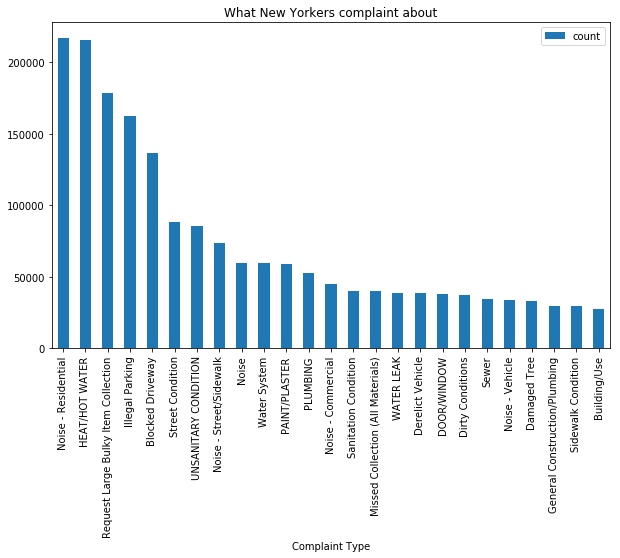

In [46]:
pdf = complain_count.toPandas()
pdf.plot(x='Complaint Type', kind='bar',figsize=(10,6),title = 'What New Yorkers complaint about')
plt.savefig('most_frequent_complaints.png',bbox_inches='tight')

In [47]:
#Calculate complaints by boroughs
complain_count_by_borough= spark.sql("SELECT Borough,`Complaint Type`, count(*) as count from nyc311 GROUP BY Borough,`Complaint Type`")

In [48]:
complain_count_by_borough_pdf = complain_count_by_borough.toPandas()

In [49]:
borough_names= clean_df.select('Borough').distinct()
borough_names = [(name.Borough) for name in borough_names.rdd.collect()]

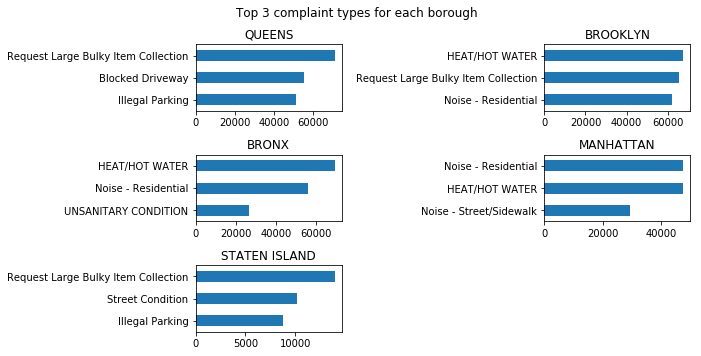

In [50]:
fig = plt.figure()

fig.suptitle('Top 3 complaint types for each borough')

count=1
for name in borough_names:
    ax=fig.add_subplot(3,2,count)
    complain_count_by_borough= spark.sql("SELECT `Complaint Type`, count(*) as count from nyc311 WHERE Borough = '"+ name + "' GROUP BY `Complaint Type` ORDER BY count DESC LIMIT 3")
    complain_count_by_borough_pdf=complain_count_by_borough.toPandas()
    complain_count_by_borough_pdf.sort_values(by='count', ascending=True).plot(x='Complaint Type', kind='barh',figsize=(10,5),ax=ax, legend=False)
    ax.set_title(name)
    count=count+1
    plt.ylabel("") 

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig('top_3_complains.png',bbox_inches='tight')
plt.show()

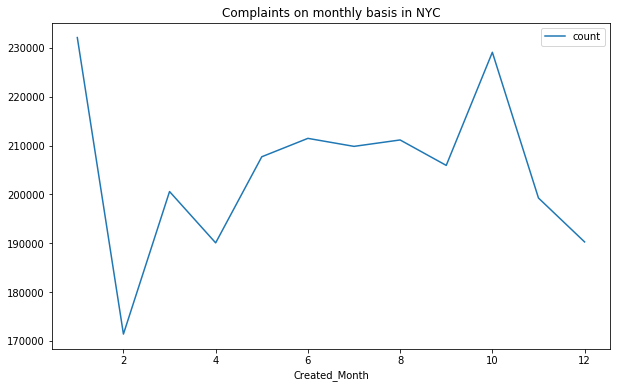

In [51]:
#Incidents on monthly basis
complain_count_per_month= spark.sql("SELECT Created_Month, count(*) as count from nyc311 GROUP BY Created_Month ORDER BY Created_Month DESC")
month_pdf = complain_count_per_month.toPandas()
month_pdf.plot(x='Created_Month', kind='line',figsize=(10,6),title = 'Complaints on monthly basis in NYC')
plt.savefig('monthly_complaint_distribution.png')

In [52]:
borough_month_pdf= spark.sql("SELECT Borough, Created_Month, count(*) as count from nyc311 GROUP BY Borough, Created_Month ORDER BY Created_Month").toPandas()

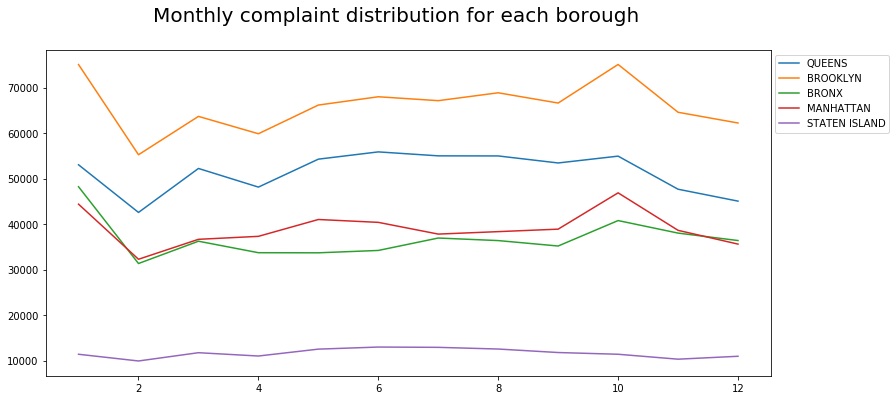

In [53]:
fig = plt.figure(figsize=(13,6))
fig.suptitle('Monthly complaint distribution for each borough',fontsize=20)

for name in borough_names:
    plt.plot(borough_month_pdf[borough_month_pdf['Borough']==name]['Created_Month'],borough_month_pdf[borough_month_pdf['Borough']==name]['count'],label=name)
plt.legend(bbox_to_anchor=(1.17,1),loc='upper right')    
plt.savefig('monthly_complaint_distribution_borough.png', bbox_inches='tight')
plt.show()

In [54]:
processing_borough__pdf= spark.sql("SELECT Borough, avg(Processing_Time) as Average from nyc311 GROUP BY Borough ORDER BY Average DESC").toPandas()

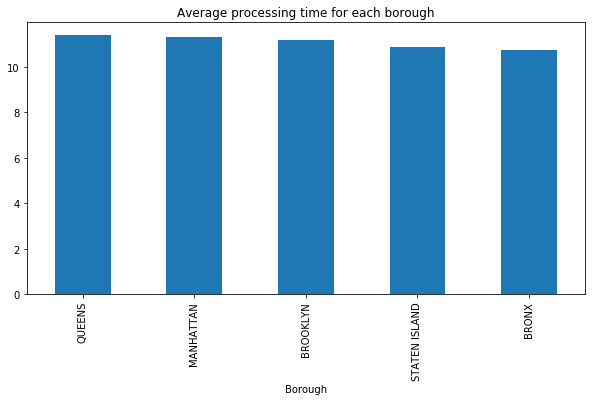

In [55]:
processing_borough__pdf.plot(x='Borough', kind='bar',figsize=(10,5), legend=False, title ="Average processing time for each borough")
plt.savefig('average_processing_time.png',bbox_inches='tight')
plt.show()

In [56]:
#Heat/Hot water incidents on monthly basis
heat_complain_count_per_month= spark.sql("SELECT Created_Month as Month, count(*) as count from nyc311 WHERE `Complaint Type` = 'HEAT/HOT WATER' GROUP BY Created_Month ORDER BY Created_Month DESC")

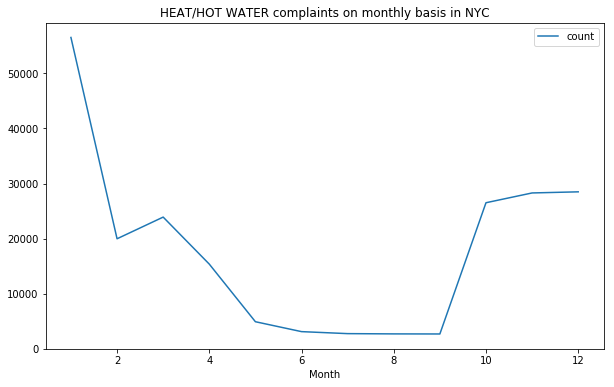

In [57]:
heat_month_pdf = heat_complain_count_per_month.toPandas()
heat_month_pdf.plot(x='Month', kind='line',figsize=(10,6),title = 'HEAT/HOT WATER complaints on monthly basis in NYC')
plt.savefig('heat_monthly.png',bbox_inches='tight')

In [58]:
heat_complain_count_per_hour= spark.sql("SELECT hour(`Created Date`) as hour, count(*) as count FROM nyc311 WHERE `Complaint Type` = 'HEAT/HOT WATER' GROUP BY hour(`Created Date`) ORDER BY hour") 

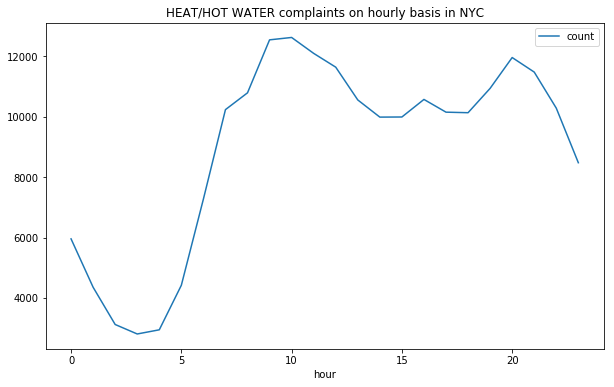

In [59]:
heat_complain_count_per_hour_pdf=heat_complain_count_per_hour.toPandas()
heat_complain_count_per_hour_pdf.plot(x='hour', kind='line',figsize=(10,6),title = 'HEAT/HOT WATER complaints on hourly basis in NYC')
plt.savefig('heat_hourly.png',bbox_inches='tight')

In [60]:
noise_complain_count_per_month= spark.sql("SELECT Created_Month, count(*) as count from nyc311 WHERE `Complaint Type` = 'Noise - Residential' GROUP BY Created_Month ORDER BY Created_Month")

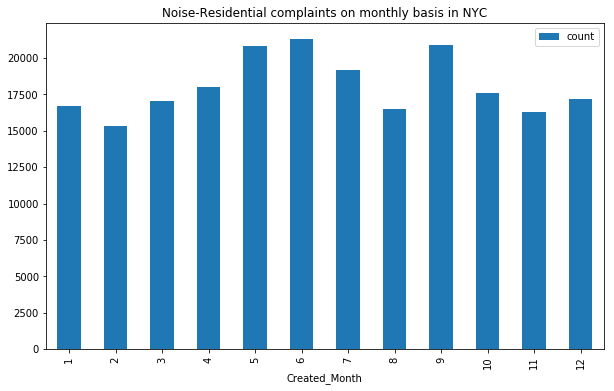

In [61]:
noise_month_pdf = noise_complain_count_per_month.toPandas()
noise_month_pdf.plot(x='Created_Month', kind='bar',figsize=(10,6),title = 'Noise-Residential complaints on monthly basis in NYC')
plt.savefig('noise_monthly.png',bbox_inches='tight')

In [62]:
noise_complain_count_per_hour= spark.sql("SELECT hour(`Created Date`) as hour, count(*) as count FROM nyc311 WHERE `Complaint Type` = 'Noise - Residential' GROUP BY hour(`Created Date`) ORDER BY hour") 

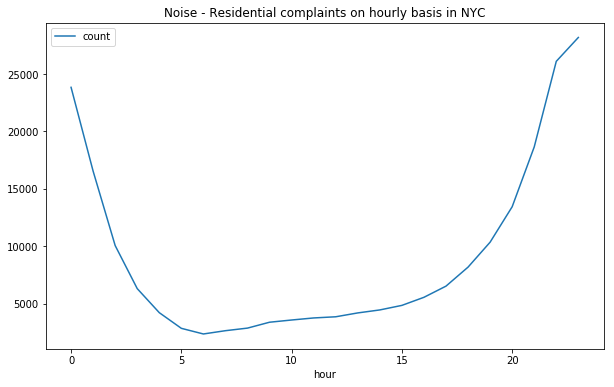

In [63]:
noise_complain_count_per_hour_pdf=noise_complain_count_per_hour.toPandas()
noise_complain_count_per_hour_pdf.plot(x='hour', kind='line',figsize=(10,6),title = 'Noise - Residential complaints on hourly basis in NYC')
plt.savefig('noise_hourly.png',bbox_inches='tight')

In [64]:
noise_complain_desc= spark.sql("SELECT Descriptor, count(*) as count from nyc311 WHERE `Complaint Type` = 'Noise - Residential' GROUP BY Descriptor ORDER BY count")

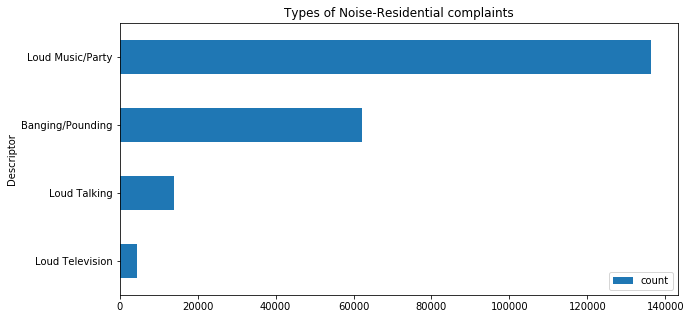

In [65]:
noise_complain_desc_pdf=noise_complain_desc.toPandas()
noise_complain_desc_pdf.plot(x='Descriptor', kind='barh',figsize=(10,5),title = 'Types of Noise-Residential complaints')
plt.savefig('noise_desc.png',bbox_inches='tight')

In [66]:
# Change the path where housing dataset in located in dumbo 
housing_dataset="/user/shs572/Housing_New_York_Units_by_Building.csv"

In [67]:
housing_df = spark.read.format('csv').options(header='true',inferschema='true').load(housing_dataset)

In [68]:
List of housing data columns
housing_df.columns

['Project ID',
 'Project Name',
 'Project Start Date',
 'Project Completion Date',
 'Building ID',
 'Number',
 'Street',
 'Borough',
 'Postcode',
 'BBL',
 'BIN',
 'Community Board',
 'Council District',
 'Census Tract',
 'NTA - Neighborhood Tabulation Area',
 'Latitude',
 'Longitude',
 'Latitude (Internal)',
 'Longitude (Internal)',
 'Building Completion Date',
 'Reporting Construction Type',
 'Extended Affordability Only',
 'Prevailing Wage Status',
 'Extremely Low Income Units',
 'Very Low Income Units',
 'Low Income Units',
 'Moderate Income Units',
 'Middle Income Units',
 'Other Income Units',
 'Studio Units',
 '1-BR Units',
 '2-BR Units',
 '3-BR Units',
 '4-BR Units',
 '5-BR Units',
 '6-BR+ Units',
 'Unknown-BR Units',
 'Counted Rental Units',
 'Counted Homeownership Units',
 'All Counted Units',
 'Total Units']

In [69]:
clean_housing_df =housing_df.drop('Building ID', 'Number', 'Street','Postcode', 'BBL', 'BIN', 'Community Board', 'Council District', 'Census Tract',
 'NTA - Neighborhood Tabulation Area', 'Building Completion Date', 'Reporting Construction Type', 'Extended Affordability Only',
 'Prevailing Wage Status', 'Extremely Low Income Units', 'Very Low Income Units', 'Low Income Units', 'Moderate Income Units',
 'Middle Income Units', 'Other Income Units', 'Studio Units', '1-BR Units', '2-BR Units', '3-BR Units', '4-BR Units', '5-BR Units',
 '6-BR+ Units', 'Unknown-BR Units')

In [70]:
clean_housing_df.columns

['Project ID',
 'Project Name',
 'Project Start Date',
 'Project Completion Date',
 'Borough',
 'Latitude',
 'Longitude',
 'Latitude (Internal)',
 'Longitude (Internal)',
 'Counted Rental Units',
 'Counted Homeownership Units',
 'All Counted Units',
 'Total Units']

In [71]:
clean_housing_df.createOrReplaceTempView("housing")

In [72]:
rental_borough = spark.sql("SELECT Borough, sum(`Counted Rental Units`) as Rental FROM housing GROUP BY Borough Order By Borough")
rental_borough_pdf = rental_borough.toPandas()

In [73]:
heat_complain_borough = spark.sql("SELECT Borough, count(*) as count from nyc311 WHERE `Complaint Type` = 'HEAT/HOT WATER' GROUP BY Borough ORDER BY Borough")
heat_complain_borough_pdf = heat_complain_borough.toPandas()

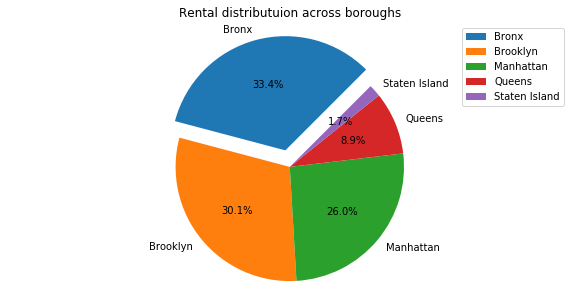

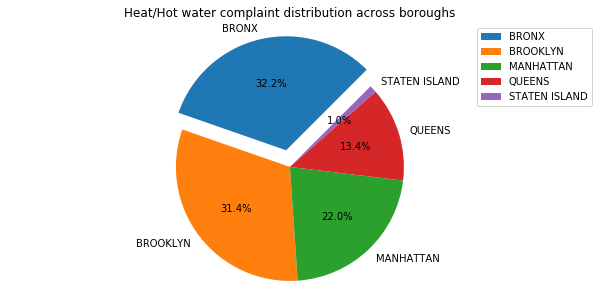

In [74]:
rental_borough_pdf.plot(x='Borough', y= 'Rental', kind='pie',figsize=(10,5), title ="Rental distributuion across boroughs",autopct='%1.1f%%',
                        explode = (0.15, 0, 0, 0, 0), startangle=45, shadow=False, labels=rental_borough_pdf['Borough'])
plt.ylabel("")
plt.axis('equal')
plt.savefig('heatvsrent1.png',bbox_inches='tight')
heat_complain_borough_pdf.plot(x='Borough', y= 'count', kind='pie',figsize=(10,5), title ="Heat/Hot water complaint distribution across boroughs",autopct='%1.1f%%',
                        explode = (0.15, 0, 0, 0, 0), startangle=45, shadow=False, labels=heat_complain_borough_pdf['Borough'])
plt.legend(bbox_to_anchor=(1.05,1),loc='upper right') 
plt.ylabel("")
plt.axis('equal')
plt.savefig('heatvsrent2.png',bbox_inches='tight')
plt.show()

In [75]:
rental_borough = spark.sql("SELECT Borough, sum(`Counted Rental Units`) as Rental, sum(`Total Units`) as Total FROM housing GROUP BY Borough Order By Borough").show()

+-------------+------+-------+
|      Borough|Rental|  Total|
+-------------+------+-------+
|        Bronx| 37212|42666.0|
|     Brooklyn| 33505|53831.0|
|    Manhattan| 28932|53389.0|
|       Queens|  9898|15641.0|
|Staten Island|  1936| 2756.0|
+-------------+------+-------+

